In [ ]:
import pandas as pd
import os
import glob
import re
import numpy as np
import shap
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# ==========================================
# 1. SETUP OUTPUT DIRECTORY
# ==========================================
data_path = "...." # UPDATE BEFORE RUNNING

output_dir = '....' # UPDATE BEFORE RUNNING

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}\n")

#### Read in the fraclac data ###
FracLac1_CIH = pd.read_csv(os.path.join(data_path, "Hull and Circle Results CIH.txt"), sep='\t', header=None)

# Split the first column to extract Name and ID
fraclac_cih = FracLac1_CIH[0].str.split('tif_thresholdedtif_', n=1, expand=True)
fraclac_cih.columns = ['Name', 'temp']
fraclac_cih['ID'] = fraclac_cih['temp'].str.split('tif', n=1, expand=True)[0]
fraclac_cih = fraclac_cih[['Name', 'ID']]

#### Read in the fraclac data ###
FracLac1_Controls= pd.read_csv(os.path.join(data_path, "Hull and Circle Results Controls.txt"), sep='\t', header=None)

# Split the first column to extract Name and ID
fraclac_ctl = FracLac1_Controls[0].str.split('tif_thresholdedtif_', n=1, expand=True)
fraclac_ctl.columns = ['Name', 'temp']
fraclac_ctl['ID'] = fraclac_ctl['temp'].str.split('tif', n=1, expand=True)[0]
fraclac_ctl = fraclac_ctl[['Name', 'ID']]

# Merge the two fraclac dataframes, and deduplicate
fraclac = pd.concat([fraclac_cih, fraclac_ctl]).drop_duplicates().reset_index(drop=True)
skeleton_dir = os.path.join(data_path, "CIH Microglia data/SkeletonResults/")

# Get immediate subdirectories only
subdirs = [d for d in os.listdir(skeleton_dir) 
           if os.path.isdir(os.path.join(skeleton_dir, d))]

complete_df_list = []

for subdir in subdirs:
    subdir_path = os.path.join(skeleton_dir, subdir)
    # Get CSV files in this subdirectory
    file_vec = glob.glob(os.path.join(subdir_path, "*.csv"))
    
    
    # Create an empty dataframe to add the CSV file's data to
    skeleton = pd.DataFrame(columns=[
        'Branches', 'Junctions', 'End_point_voxels', 'Junction_voxels', 
        'Slab_voxels', 'Average_Branch_Length', 'Triple_points', 
        'Quadruple_points', 'Maximum_Branch_Length', 'Name', 'ID'
    ])
    
    rows = []
    for file_path in file_vec:
        # Read in the CSV
        open_file = pd.read_csv(file_path, header=0)

        # Remove the first column (assumed to be row numbers) and add Name/ID columns
        open_file = open_file.iloc[:, 1:].copy()  # Remove first column
        open_file['Name'] = None
        open_file['ID'] = None

        open_file.columns = [col.replace("# ", "", 1).lstrip() if col.startswith("# ") else col.lstrip() for col in open_file.columns]

        open_file2 = open_file.copy()

        # Extract file name with extension, remove the extension, periods, spaces, and 'tif_results'
        base_name = os.path.basename(file_path)
        file_name_no_ext = os.path.splitext(base_name)[0]
        cleaned_name = re.sub(r' |\.|tif_results$', '', file_name_no_ext)

        # Extract Name and ID using regex
        name_match = re.search(r'(.*?)(?=tif_thresholdedtif_)', cleaned_name)
        id_match = re.search(r'(?<=tif_thresholdedtif_)(.*)', cleaned_name)

        open_file2.loc[0, 'Name'] = name_match.group(1) if name_match else None
        open_file2.loc[0, 'ID'] = id_match.group(1) if id_match else None

        # Collect just the first row for later concatenation
        rows.append(open_file2.iloc[[0]])
        
    rows_df = pd.concat(rows, ignore_index=True, sort=False)
    
    # Remove rows with NA values in Name or ID
    rows_df = rows_df.dropna(subset=['Name', 'ID']).reset_index(drop=True)
    merged_df = pd.merge(rows_df, fraclac, on=['Name', 'ID'], how='inner')

    new_cols = list(skeleton.columns) + [merged_df.columns[-1]]
    merged_df.columns = new_cols

    merged_df = merged_df.dropna(axis=1, how='all')
    
    merged_df['Groups'] = subdir

    complete_df_list.append(merged_df)
# Combine all subdirectory dataframes into one
complete_df = pd.concat(complete_df_list, ignore_index=True, sort=False)
complete_df.to_csv(os.path.join(data_path, "skeleton morphology output.csv"), index=False)
# Create the copy
complete_copy = complete_df.copy()

# Rename columns to remove underscores
complete_copy.columns = complete_copy.columns.str.replace('_', ' ')

# Now you can use metrics without underscores
metrics = ['Branches', 'Junctions', 'End point voxels', 'Junction voxels', 
           'Slab voxels', 'Average Branch Length', 'Triple points', 
           'Quadruple points', 'Maximum Branch Length']

Output directory: /home/christophery/Papers/Microglia Morphology/Data/CIH Microglia data



Classes found: ['CIH' 'Control']

STARTING 5-FOLD CROSS-VALIDATION
Fold 1 Accuracy: 78.03%
Fold 2 Accuracy: 78.03%
Fold 3 Accuracy: 88.64%
Fold 4 Accuracy: 87.79%
Fold 5 Accuracy: 79.39%

AVERAGED EVALUATION RESULTS
Mean Accuracy: 82.37% (+/- 4.80%)

--- Classification Report (Aggregated) ---
              precision    recall  f1-score   support

         CIH       0.67      0.87      0.76       207
     Control       0.93      0.80      0.86       451

    accuracy                           0.82       658
   macro avg       0.80      0.84      0.81       658
weighted avg       0.85      0.82      0.83       658

Saved: classification_report.txt
Saved: cross_validation_metrics.csv
Saved: confusion_matrix.csv
--- Performance Visualizations ---
Saved: confusion_matrix_and_metrics.png


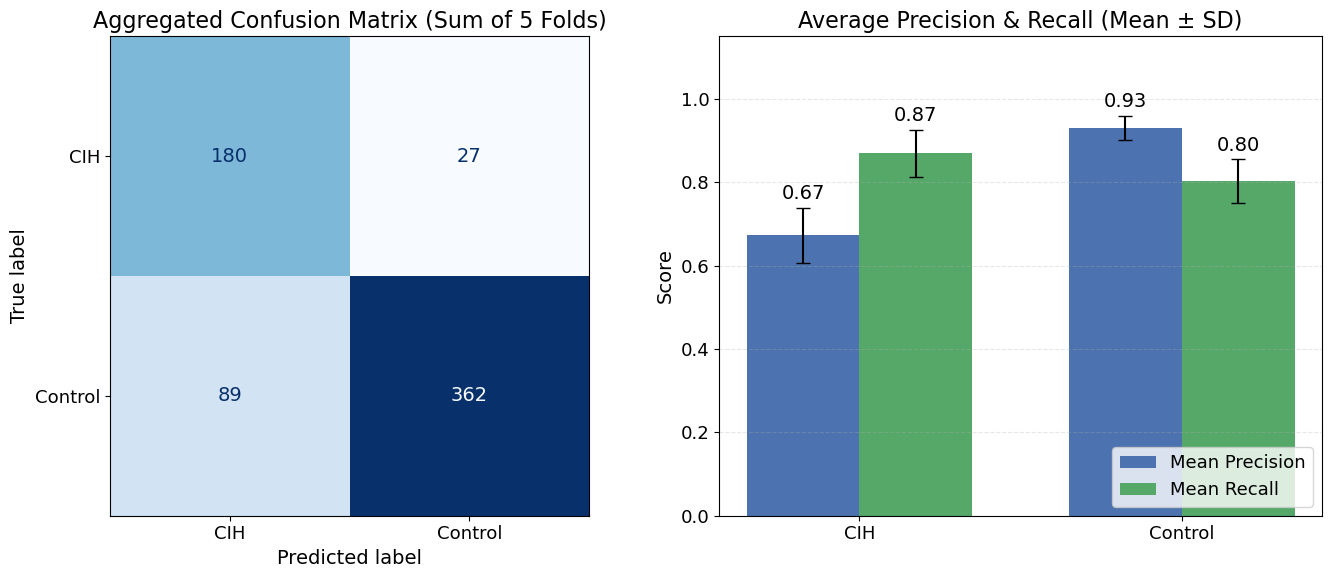

------------------------------


SHAP returned a 3D array. Concatenating and slicing for class index 0...
Shape of combined SHAP values: (658, 9)
Shape of combined data: (658, 9)
Saved: shap_values_cv_output.csv
Saved: shap_beeswarm_plot.png


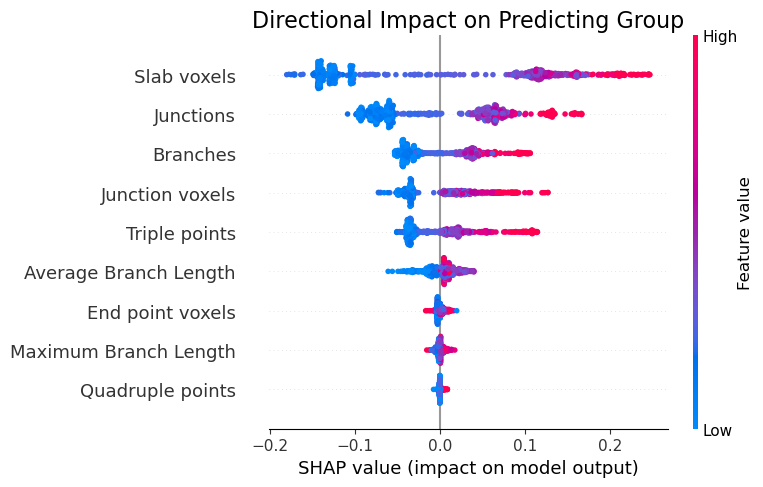

Saved: feature_importance_comparison.csv

Metric                    | Gini (SD)       | Mean |SHAP|
------------------------------------------------------------
Slab voxels               | 0.3702 (0.029) | 0.1294
Junctions                 | 0.2119 (0.024) | 0.0697
Junction voxels           | 0.1262 (0.012) | 0.0373
Branches                  | 0.1232 (0.017) | 0.0402
Triple points             | 0.1116 (0.008) | 0.0340
Average Branch Length     | 0.0258 (0.005) | 0.0125
End point voxels          | 0.0201 (0.001) | 0.0036
Maximum Branch Length     | 0.0093 (0.001) | 0.0026
Quadruple points          | 0.0017 (0.001) | 0.0009
Saved: feature_importance_agreement.png


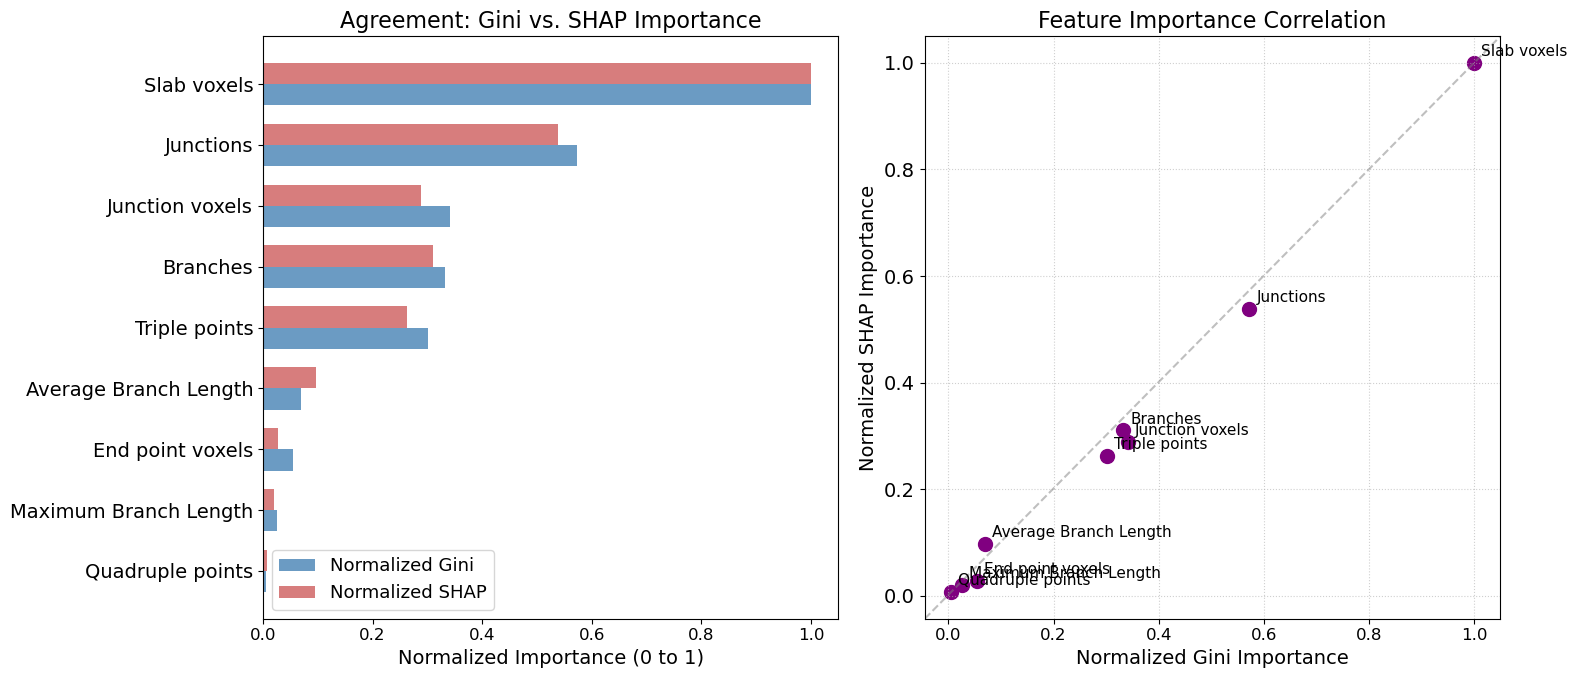

Top 3 CIH (Indices): [52, 46, 86]
Top 3 Control (Indices): [647, 219, 620]
Saved: most_varied_samples.csv
IDs to extract for CIH: ['0010-0053', '0720-0432', '0270-0204']
IDs to extract for Control: ['1509-0616', '1844-0719', '1076-0460']

ALL OUTPUTS SAVED TO: /home/christophery/Papers/Microglia Morphology/Data/CIH Microglia data


In [ ]:
# ==========================================
# 2. PREPROCESSING
# ==========================================

X = complete_copy[metrics]
y = complete_copy['Groups']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print(f"Classes found: {class_names}")

# ==========================================
# 3. CROSS-VALIDATION TRAINING
# ==========================================
print("\n" + "="*40)
print("STARTING 5-FOLD CROSS-VALIDATION")
print("="*40)

# Initialize 5-fold Stratified Cross-Validation
# Stratified ensures each fold has the same proportion of Groups as the whole data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Lists to store metrics across folds
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

# Variables to aggregate results
total_confusion_matrix = np.zeros((len(class_names), len(class_names)), dtype=int)
all_y_test = []
all_y_pred = []
all_test_indices = []
fold_rf_importances = []

# Storage for SHAP
shap_values_list = [] 

fold_num = 1
for train_index, test_index in skf.split(X, y_encoded):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=3)
    model.fit(X_train, y_train)
    fold_rf_importances.append(model.feature_importances_)
    # Predict
    y_pred = model.predict(X_test)
    
    # Store Metrics
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)
    
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
    fold_precisions.append(p)
    fold_recalls.append(r)
    fold_f1s.append(f)
    
    # Aggregate for Global Confusion Matrix
    total_confusion_matrix += confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_test_indices.extend(test_index)

    # SHAP Calculation for this fold (test set)
    explainer = shap.TreeExplainer(model)
    fold_shap_values = explainer.shap_values(X_test, check_additivity=False)
    shap_values_list.append(fold_shap_values)

    print(f"Fold {fold_num} Accuracy: {acc:.2%}")
    fold_num += 1

# ==========================================
# 4. MODEL EVALUATION (Averaged with Error Bars)
# ==========================================
print("\n" + "="*40)
print("AVERAGED EVALUATION RESULTS")
print("="*40)

mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
print(f"Mean Accuracy: {mean_acc:.2%} (+/- {std_acc:.2%})")

mean_precision = np.mean(fold_precisions, axis=0)
std_precision = np.std(fold_precisions, axis=0)

mean_recall = np.mean(fold_recalls, axis=0)
std_recall = np.std(fold_recalls, axis=0)

mean_f1 = np.mean(fold_f1s, axis=0)
std_f1 = np.std(fold_f1s, axis=0)

# Print Text Report
print("\n--- Classification Report (Aggregated) ---")
class_report_str = classification_report(all_y_test, all_y_pred, target_names=class_names)
print(class_report_str)

# Save Classification Report
with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
    f.write("CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n\n")
    f.write(f"Mean Accuracy: {mean_acc:.2%} (+/- {std_acc:.2%})\n\n")
    f.write(class_report_str)
print(f"Saved: classification_report.txt")

# Save Cross-Validation Metrics
cv_metrics_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': fold_accuracies,
    'Precision_Class_0': [p[0] for p in fold_precisions],
    'Precision_Class_1': [p[1] for p in fold_precisions],
    'Recall_Class_0': [r[0] for r in fold_recalls],
    'Recall_Class_1': [r[1] for r in fold_recalls],
    'F1_Class_0': [f[0] for f in fold_f1s],
    'F1_Class_1': [f[1] for f in fold_f1s]
})
cv_metrics_df.to_csv(os.path.join(output_dir, 'cross_validation_metrics.csv'), index=False)
print(f"Saved: cross_validation_metrics.csv")

# Save Confusion Matrix
cm_df = pd.DataFrame(total_confusion_matrix, 
                     index=[f'True_{cls}' for cls in class_names],
                     columns=[f'Pred_{cls}' for cls in class_names])
cm_df.to_csv(os.path.join(output_dir, 'confusion_matrix.csv'))
print(f"Saved: confusion_matrix.csv")

# --- Visualizations ---
print("--- Performance Visualizations ---")

# Set larger font sizes for plots
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13
})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Aggregated Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=total_confusion_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=axes[0], colorbar=False)
axes[0].set_title("Aggregated Confusion Matrix (Sum of 5 Folds)")

# Subplot 2: Mean Precision & Recall WITH ERROR BARS
x = np.arange(len(class_names))
width = 0.35

rects1 = axes[1].bar(x - width/2, mean_precision, width, 
                     yerr=std_precision, capsize=5, 
                     label='Mean Precision', color='#4c72b0')

rects2 = axes[1].bar(x + width/2, mean_recall, width, 
                     yerr=std_recall, capsize=5, 
                     label='Mean Recall', color='#55a868')

axes[1].set_ylabel('Score')
axes[1].set_title('Average Precision & Recall (Mean ± SD)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names)
axes[1].set_ylim(0, 1.15)
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

# Label function
def autolabel(rects, std_devs):
    for rect, sd in zip(rects, std_devs):
        height = rect.get_height()
        # Place label at height + sd + small offset
        axes[1].annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height + sd),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, std_precision)
autolabel(rects2, std_recall)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix_and_metrics.png'), dpi=300, bbox_inches='tight')
print(f"Saved: confusion_matrix_and_metrics.png")
plt.show()
print("-" * 30)

# ==========================================
# 5. SHAP ANALYSIS
# ==========================================
shap.initjs()

X_combined = X.iloc[all_test_indices]
y_combined = np.array(all_y_test)
sample_output = shap_values_list[0]

if isinstance(sample_output, list):
    # RF returns list of arrays [class0, class1]
    print("SHAP returned a list. Concatenating positive class (index 1)...")
    vals_to_plot = np.concatenate([fold_vals[1] for fold_vals in shap_values_list], axis=0)
    
elif len(sample_output.shape) == 3:
    # 3D Array [samples, features, classes]
    print("SHAP returned a 3D array. Concatenating and slicing for class index 0...")
    stacked = np.concatenate(shap_values_list, axis=0)
    vals_to_plot = stacked[:, :, 0]
    
else:
    # 2D Array
    print("SHAP returned 2D arrays. Concatenating...")
    vals_to_plot = np.concatenate(shap_values_list, axis=0)

print(f"Shape of combined SHAP values: {vals_to_plot.shape}")
print(f"Shape of combined data: {X_combined.shape}")

shap_df = pd.DataFrame(vals_to_plot, columns=metrics)
shap_df['True_Class'] = le.inverse_transform(y_combined)
shap_df.to_csv(os.path.join(output_dir, 'shap_values_cv_output.csv'), index=False)
print(f"Saved: shap_values_cv_output.csv")

# ==========================================
# 6. VISUALIZATIONS
# ==========================================
# Plot 2: Beeswarm Plot
plt.rc('font', size=14)  # Increase SHAP plot font size
plt.figure(figsize=(10, 6))
shap.summary_plot(vals_to_plot, X_combined, show=False)
plt.title("Directional Impact on Predicting Group", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'shap_beeswarm_plot.png'), dpi=300, bbox_inches='tight')
print(f"Saved: shap_beeswarm_plot.png")
plt.show()

# ==========================================
# 7. FEATURE HIERARCHY & AGREEMENT
# ==========================================

# 1. Prepare SHAP Importance (Mean Absolute SHAP)
mean_abs_shap = np.mean(np.abs(vals_to_plot), axis=0)

# 2. Prepare RF Gini Importance (Mean across folds)
mean_rf_importance = np.mean(fold_rf_importances, axis=0)
std_rf_importance = np.std(fold_rf_importances, axis=0)

importance_df = pd.DataFrame({
    'Metric': metrics,
    'RF_Gini': mean_rf_importance,
    'Gini_SD': std_rf_importance,
    'SHAP_Abs': mean_abs_shap
})

importance_df['RF_Gini_Norm'] = importance_df['RF_Gini'] / importance_df['RF_Gini'].max()
importance_df['SHAP_Abs_Norm'] = importance_df['SHAP_Abs'] / importance_df['SHAP_Abs'].max()
importance_df['Agreement_Diff'] = np.abs(importance_df['RF_Gini_Norm'] - importance_df['SHAP_Abs_Norm'])

importance_df = importance_df.sort_values(by='RF_Gini', ascending=False)

importance_df.to_csv(os.path.join(output_dir, 'feature_importance_comparison.csv'), index=False)
print(f"Saved: feature_importance_comparison.csv")

print("\n" + "="*60)
print(f"{'Metric':<25} | {'Gini (SD)':<15} | {'Mean |SHAP|'}")
print("-" * 60)
for _, row in importance_df.iterrows():
    print(f"{row['Metric']:<25} | {row['RF_Gini']:.4f} ({row['Gini_SD']:.3f}) | {row['SHAP_Abs']:.4f}")

# --- Visualizing Agreement ---
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 14,
    'legend.fontsize': 13
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Side-by-Side Comparison
x_indices = np.arange(len(importance_df))
width = 0.35

ax1.barh(x_indices + width/2, importance_df['RF_Gini_Norm'], width, label='Normalized Gini', color='steelblue', alpha=0.8)
ax1.barh(x_indices - width/2, importance_df['SHAP_Abs_Norm'], width, label='Normalized SHAP', color='indianred', alpha=0.8)

ax1.set_yticks(x_indices)
ax1.set_yticklabels(importance_df['Metric'])
ax1.set_xlabel('Normalized Importance (0 to 1)')
ax1.set_title('Agreement: Gini vs. SHAP Importance')
ax1.invert_yaxis()
ax1.legend()

ax2.scatter(importance_df['RF_Gini_Norm'], importance_df['SHAP_Abs_Norm'], s=100, color='purple')
for i, txt in enumerate(importance_df['Metric']):
    ax2.annotate(txt, (importance_df['RF_Gini_Norm'].iloc[i], importance_df['SHAP_Abs_Norm'].iloc[i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=11)

ax2.plot([0, 1], [0, 1], transform=ax2.transAxes, linestyle='--', color='gray', alpha=0.5)
ax2.set_xlabel('Normalized Gini Importance')
ax2.set_ylabel('Normalized SHAP Importance')
ax2.set_title('Feature Importance Correlation')
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance_agreement.png'), dpi=300, bbox_inches='tight')
print(f"Saved: feature_importance_agreement.png")
plt.show()

# ==========================================
# 8. MOST VARIED SAMPLES
# ==========================================
all_probs = model.predict_proba(X_combined) 

search_df = pd.DataFrame({
    'True_Class': y_combined,
    'Pred_Class': all_y_pred,
    'Confidence': np.max(all_probs, axis=1) 
}, index=X_combined.index)

correct_df = search_df[search_df['True_Class'] == search_df['Pred_Class']]

top_3_CIH = correct_df[correct_df['True_Class'] == 0].sort_values('Confidence', ascending=False).head(3)
top_3_Control = correct_df[correct_df['True_Class'] == 1].sort_values('Confidence', ascending=False).head(3)

print(f"Top 3 {class_names[0]} (Indices): {top_3_CIH.index.tolist()}")
print(f"Top 3 {class_names[1]} (Indices): {top_3_Control.index.tolist()}")

# ==========================================
# 9. CREATE DATAFRAMES FOR IMAGE EXTRACTION
# ==========================================
deviated_complete_CIH = complete_df.loc[top_3_CIH.index]
deviated_complete_Control = complete_df.loc[top_3_Control.index]

# Save most varied samples
deviated_samples_info = pd.concat([deviated_complete_CIH, deviated_complete_Control], ignore_index=True)
deviated_samples_info.to_csv(os.path.join(output_dir, 'most_varied_samples.csv'), index=False)
print(f"Saved: most_varied_samples.csv")

if 'ID' in complete_df.columns:
    print(f"IDs to extract for {class_names[0]}: {deviated_complete_CIH['ID'].tolist()}")
    print(f"IDs to extract for {class_names[1]}: {deviated_complete_Control['ID'].tolist()}")

print("\n" + "="*60)
print(f"ALL OUTPUTS SAVED TO: {output_dir}")
print("="*60)

In [ ]:
import os
import shutil
import pandas as pd

def extract_images(target_ids, source_folders, dest_folder):
    """
    Scans source_folders for files that contain any of the target_ids in their name
    and copies them to dest_folder.
    """
    # 1. Create destination directory
    os.makedirs(dest_folder, exist_ok=True)
    
    # Clean IDs: remove duplicates and ensure they are strings
    unique_ids = list(set(str(x) for x in target_ids if pd.notna(x)))
    copied_count = 0

    # 2. Search and Copy
    for folder in source_folders:
        if not os.path.exists(folder):
            continue
            
        for root, dirs, files in os.walk(folder):
            for filename in files:
                # Check: Does the filename contain ANY of our IDs?
                if any(tid in filename for tid in unique_ids):
                    src_path = os.path.join(root, filename)
                    dst_path = os.path.join(dest_folder, filename)
                    
                    try:
                        shutil.copy2(src_path, dst_path)
                        copied_count += 1
                        print(f"Copied: {filename}")
                    except Exception as e:
                        print(f"Error copying {filename}: {e}")

    print(f"\nFinished. Copied {copied_count} images to '{dest_folder}'.")
    
# Concartenate the deviated samples
deviated_samples_df = pd.concat([deviated_complete_CIH, deviated_complete_Control], ignore_index=True)

source_dirs = [
    os.path.join(output_dir, 'CIH'),
    os.path.join(output_dir, 'Controls')
]
dest_dir = os.path.join(output_dir, 'Deviated')

ids_to_find = deviated_samples_df['ID'].tolist()

extract_images(ids_to_find, source_dirs, dest_dir)
